<a href="https://colab.research.google.com/github/sbathwal1999/Text-Analysis/blob/main/TXTA_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset contains reviews from people on different aspect of Banking.<br><br>
Objective is to :
1. Based on Comments/Reviews form a word cloud of most commonly occuring words.
2. Based on Comments/Reviews form a word cloud of most commonly occuring words for Individual/Specific Bank.
3. Based on Comments/Reviews try to find most important words that help classify the Title.
4. Based on Comments/Reviews try to find most important words that help classify the Title for Individual/Specific Bank.
5. Based on Comments/Reviews try to classify the Title.
6. Based on Comments/Reviews try to classify it as positive or negative review.

# Loading Libraries and Dataset

In [165]:
import pandas as pd
import numpy as np

import re       #regex expression : String Pattern
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer    #Term Frequency - Inverse Document Frequency : Quantify words in a set of documents
from wordcloud import WordCloud,STOPWORDS     #WordCloud : Make wordcloud, Stopwords - Non Important words
import wordcloud

from sklearn.decomposition import TruncatedSVD      #Truncated Singular Value Decomposition
from scipy.sparse.linalg import svds
from sklearn.manifold import TSNE       #TSNE : High Dimensional Data Visual

from sklearn import preprocessing
from sklearn.metrics import pairwise_distances  #Distance Matrix

import warnings
warnings.filterwarnings("ignore")

For easy access, I uploaded the csv file in my github public account

In [166]:
!wget https://raw.githubusercontent.com/sbathwal1999/Text-Analysis/main/A21--31.csv

--2022-02-20 14:20:46--  https://raw.githubusercontent.com/sbathwal1999/Text-Analysis/main/A21--31.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1906406 (1.8M) [text/plain]
Saving to: ‘A21--31.csv.4’

A21--31.csv.4       100%[===================>]   1.82M  --.-KB/s    in 0.07s   

2022-02-20 14:20:46 (26.6 MB/s) - ‘A21--31.csv.4’ saved [1906406/1906406]



Reading the file

In [167]:
df = pd.read_csv("/content/A21--31.csv")

Instance of Dataset

In [168]:
df.head()

,Title,Heading,Reviewer,Date,Review,Bank,Rating
0,Saving Account,Easy to access and branch experience is good,VLJ,2019-07-13,Every transactions are going smoothly with my ...,Axis Bank,4.0
1,Personal Loan,You can bank on Axis bank any time,JADHAV,2019-07-13,I have not provided any documents and straight...,Axis Bank,4.0
2,Credit Card,Easy to access the axis bank,LAKSHMIKANTH,2019-07-13,Axis bank given me a personal loan based on my...,Axis Bank,4.0
3,Saving Account,Excellent service,L,2019-07-13,My salary account is with Axis Bank. There is ...,Axis Bank,5.0
4,Personal Loan,Good,SE,2019-07-13,I was eligible for Axis bank Personal Loan and...,Axis Bank,4.0


Dataset contains reviews from people on different aspect of Banking.

1. Title Column contains the aspect of Banking for which the reveiewer wrote the review.
2. Heading stores the title of the review as specified by the reviewer.
3. Reviewer stores the name of the reviewer.
4. Date stores the date of the review.
5. Review stores the review as given by the reviewer.
6. Banks stores the name of the Bank.
7. Ratings contains the rating on the scale of 5.

# Data Cleaning

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     4969 non-null   object 
 1   Heading   4969 non-null   object 
 2   Reviewer  4967 non-null   object 
 3   Date      4969 non-null   object 
 4   Review    4969 non-null   object 
 5   Bank      4969 non-null   object 
 6   Rating    4969 non-null   float64
dtypes: float64(1), object(6)
memory usage: 271.9+ KB


Checking for Null Values

In [170]:
df.isnull().sum()

Title       0
Heading     0
Reviewer    2
Date        0
Review      0
Bank        0
Rating      0
dtype: int64

Only two null value.<br>Dropping the rows

In [171]:
df.dropna(inplace=True)

Checking for duplicates

In [172]:
df.duplicated().sum()

127

127 duplicate values!<br>
Will hamper model performation dropping them

In [173]:
df.drop_duplicates(inplace=True,keep='first')

Data Consistency

In [174]:
#Substituting dash with space
df['Bank'] = df['Bank'].apply(lambda x: x.replace("-"," "))

In [175]:
#Clubbing different Loan type with very low count into one
df['Title'] = df['Title'].apply(lambda x: 'Other Loan' if (x=='Education Loan')|(x=='Two Wheeler Loan')|(x=='Loan Against Property') else x)

In [176]:
#Forming a single deposit title
df['Title'] = df['Title'].apply(lambda x: 'Deposit' if 'Deposit' in x else x)

# Outlier Treatment

Checking for Outliers

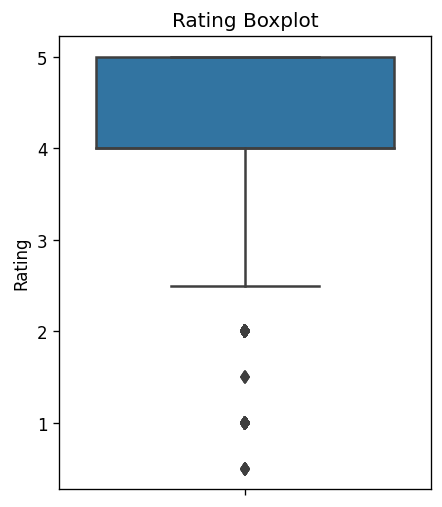

In [177]:
plt.figure(figsize = (4,5),dpi=120)
sns.boxplot(y = 'Rating',data=df)
plt.title('Rating Boxplot')
plt.ylabel('Rating')
plt.show()

We got some outliers<br>Getting rid of them

In [178]:
#Ratings with absolute z greater than 3 - dropping those rows
z = (df['Rating']-df['Rating'].mean())/df['Rating'].std()
df = df[(z>-3)&(z<3)]

# Basic Preprocessing

Lowering the case and removing numerics and special symbols

In [179]:
df['corpus'] = df['Review'].apply(lambda x: re.sub("[^a-zA-z ']+","",x).lower().strip())
#df['corpus_head'] = df['Heading'].apply(lambda x: re.sub("[^a-zA-z ]+","",x).lower().strip())

It was seen that in many of the reviews bank name was specified that do not add anything to the analysis.<br>Adding them to stopwords

In [180]:
#stopwords = list(set(' '.join([" ".join(df['Title'].value_counts().index)," ".join(df['Bank'].value_counts().index)]).lower().split()))
stopwords = list(set(" ".join(df['Bank'].value_counts().index).lower().split()))
stopwords.extend(STOPWORDS)
stopwords.append('citi')

In [181]:
#Removing Stopwords
df['corpus'] = df['corpus'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

In [182]:
#Removing Most Occuring words as they wont help to classify

#from textblob import Word
#import nltk
#nltk.download('wordnet')

#most_common = list(pd.Series(' '.join(df['corpus']).split()).value_counts()[:10].index)
#df['corpus_cleaned'] = df['corpus'].apply(lambda x: " ".join(x for x in x.split() if x not in most_common))

#Removing Least Common words as they wont help to classify
#least_common = list(pd.Series(' '.join(df['corpus_cleaned']).split()).value_counts()[-15:].index)
#df['corpus_cleaned'] = df['corpus_cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in least_common))

#Lemmatisation 
#df['corpus_cleaned'] = df['corpus_cleaned'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


#-------- Tried this, model performance decreased ---------

In [183]:
df.head()

,Title,Heading,Reviewer,Date,Review,Bank,Rating,corpus
0,Saving Account,Easy to access and branch experience is good,VLJ,2019-07-13,Every transactions are going smoothly with my ...,Axis Bank,4.0,every transactions going smoothly savings acco...
1,Personal Loan,You can bank on Axis bank any time,JADHAV,2019-07-13,I have not provided any documents and straight...,Axis Bank,4.0,provided documents straightaway amount credite...
2,Credit Card,Easy to access the axis bank,LAKSHMIKANTH,2019-07-13,Axis bank given me a personal loan based on my...,Axis Bank,4.0,given personal loan based credit card usage tr...
3,Saving Account,Excellent service,L,2019-07-13,My salary account is with Axis Bank. There is ...,Axis Bank,5.0,salary account minimum balance salary account ...
4,Personal Loan,Good,SE,2019-07-13,I was eligible for Axis bank Personal Loan and...,Axis Bank,4.0,eligible personal loan proceeded forward apply...


# Basic EDA

Basic Description of the columns

In [184]:
df.describe(),

(            Rating
 count  4681.000000
 mean      4.239692
 std       0.854296
 min       1.500000
 25%       4.000000
 50%       4.000000
 75%       5.000000
 max       5.000000,)

In [185]:
df.describe(include="O")

,Title,Heading,Reviewer,Date,Review,Bank,corpus
count,4681,4681,4681,4681,4681,4681,4681
unique,9,1213,3581,907,4662,5,4645
top,Saving Account,Good service,S,2019-06-08,My salary account is with Bank of India. The s...,Bank Of India,good experience far salary account last years ...
freq,1839,494,27,71,2,950,3


DataTypes

In [186]:
categorical = [feature for feature in df.columns if df[feature].dtype=='O']
numerical = [feature for feature in df.columns if df[feature].dtype!='O']

print(f'Dataset has {len(categorical)} categorical columns. Columns : {categorical}')
print(f'Dataset has {len(numerical)} continuous numerical columns. Columns : {numerical}')

Dataset has 7 categorical columns. Columns : ['Title', 'Heading', 'Reviewer', 'Date', 'Review', 'Bank', 'corpus']
Dataset has 1 continuous numerical columns. Columns : ['Rating']


In [187]:
for col in categorical:
  print(f"Number of unique values in column {col} : {df[col].nunique()}")

Number of unique values in column Title : 9
Number of unique values in column Heading : 1213
Number of unique values in column Reviewer : 3581
Number of unique values in column Date : 907
Number of unique values in column Review : 4662
Number of unique values in column Bank : 5
Number of unique values in column corpus : 4645


Unique Values

In [188]:
df['Title'].value_counts()

Saving Account     1839
Credit Card        1267
Other Loan          536
Personal Loan       512
Car Loan            289
Home Loan           164
Current Account      33
Deposit              31
All Products         10
Name: Title, dtype: int64

In [189]:
df['Bank'].value_counts()

Bank Of India          950
Citibank               945
Union Bank Of India    938
Capital First          929
Axis Bank              919
Name: Bank, dtype: int64

Year vs Rating

In [190]:
year= df['Date'].apply(lambda x: x.split('-')[0])

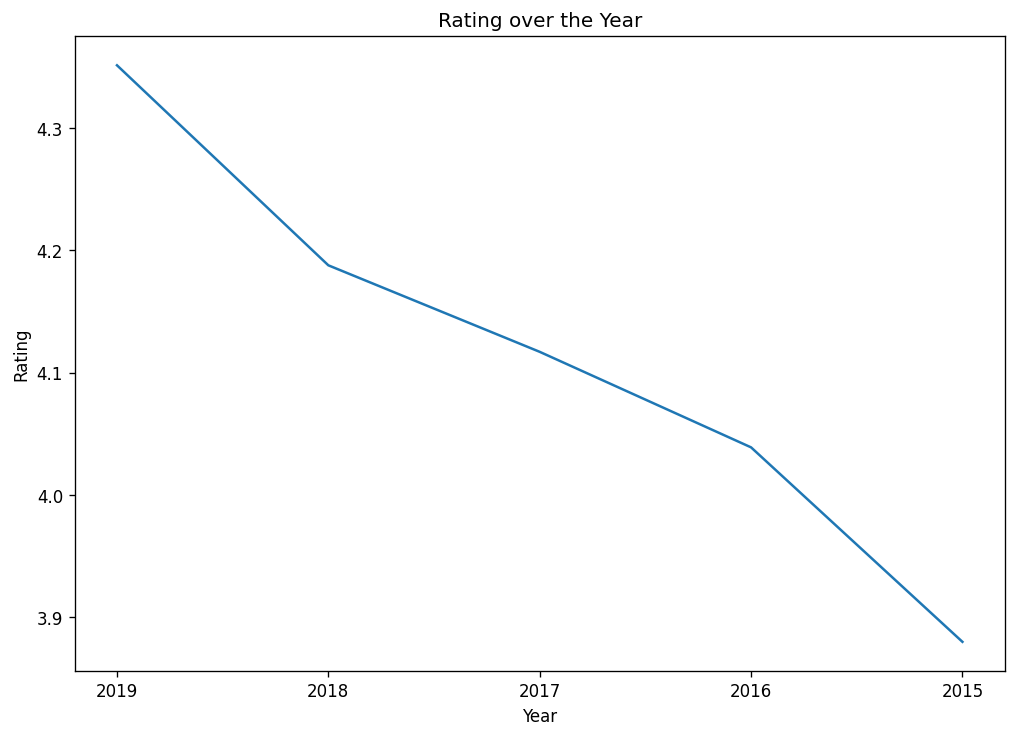

In [191]:
plt.figure(figsize = (10,7),dpi=120)
sns.lineplot(y = df['Rating'], x = year,err_style=None)
plt.title('Rating over the Year')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

Ratings of Bank increased over time

Rating vs Bank

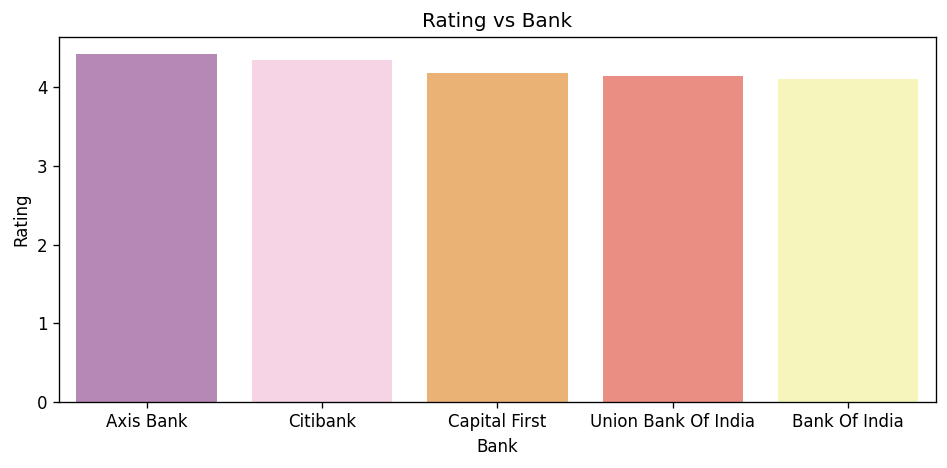

Bank
Axis Bank              4.420022
Bank Of India          4.108947
Capital First          4.177072
Citibank               4.345503
Union Bank Of India    4.150853
Name: Rating, dtype: float64

In [192]:
plt.figure(figsize = (8,4),dpi=120)
sns.barplot(y = df.groupby('Bank').mean()['Rating'], x = df.groupby('Bank').mean()['Rating'].index,data=df,palette='Set3_r',order =df.groupby('Bank').mean()['Rating'].sort_values(ascending=False).index)
plt.title('Rating vs Bank')
plt.xlabel('Bank')
plt.ylabel('Rating')
plt.tight_layout()  
plt.show()

df.groupby('Bank').mean()['Rating']

Mean Ratings of all the banks are almost the same<br>
All have ratings above 4

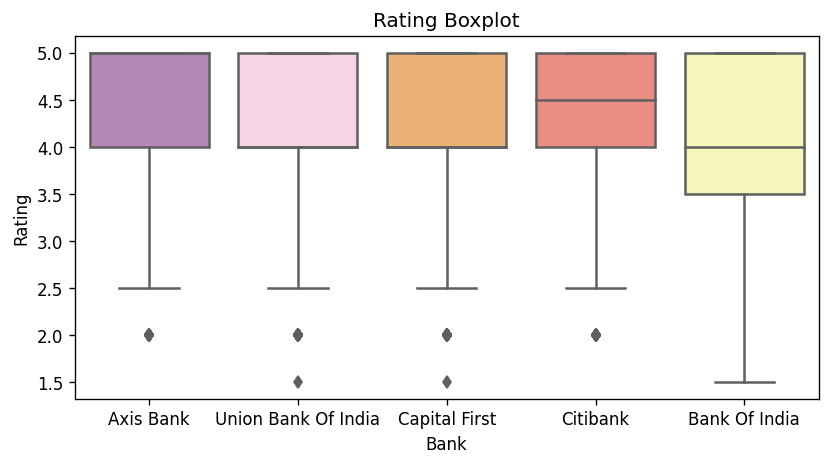

In [193]:
plt.figure(figsize = (8,4),dpi=120)
sns.boxplot(y='Rating',x='Bank',data=df,palette='Set3_r')
plt.title('Rating Boxplot')
plt.xlabel('Bank')
plt.ylabel('Rating')
plt.show()

Rating vs Title

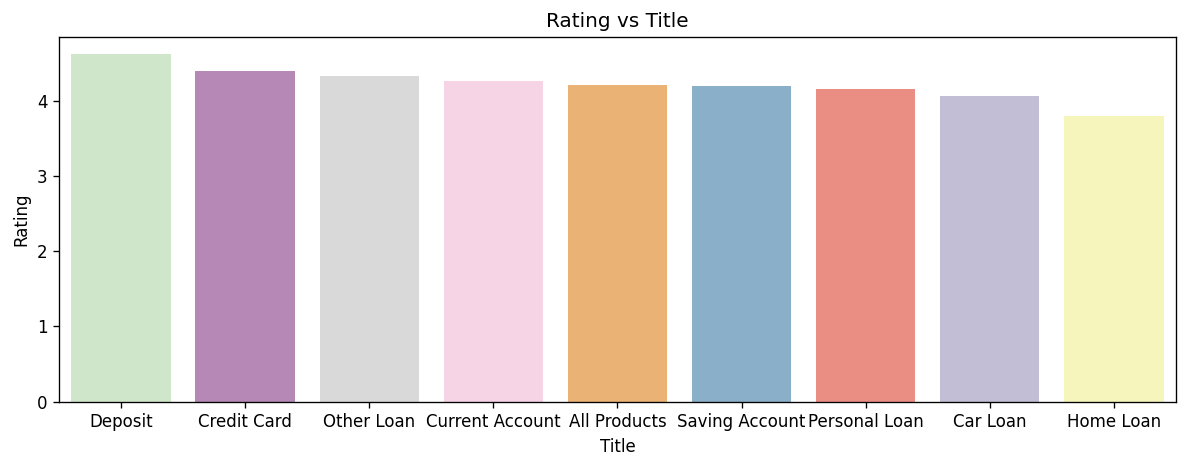

Title
All Products       4.200000
Car Loan           4.058824
Credit Card        4.390292
Current Account    4.257576
Deposit            4.612903
Home Loan          3.798780
Other Loan         4.325560
Personal Loan      4.156250
Saving Account     4.195487
Name: Rating, dtype: float64

In [194]:
plt.figure(figsize = (10,4),dpi=120)
sns.barplot(y = df.groupby('Title').mean()['Rating'], x = df.groupby('Title').mean()['Rating'].index,data=df,palette='Set3_r',order =df.groupby('Title').mean()['Rating'].sort_values(ascending=False).index)
plt.title('Rating vs Title')
plt.xlabel('Title')
plt.ylabel('Rating')
plt.tight_layout()  
plt.show()

df.groupby('Title').mean()['Rating']

Ratings of title having home loan is the least. Telling that people have problems with Home Loan

Individual Banks WordCloud

In [195]:
axis_words = " ".join(df[df['Bank']=='Axis Bank']['corpus'])
union_words = " ".join(df[df['Bank']=='Union Bank Of India']['corpus'])
capital_words = " ".join(df[df['Bank']=='Capital First']['corpus'])
citi_words = " ".join(df[df['Bank']=='Citibank']['corpus'])
boi_words = " ".join(df[df['Bank']=='Bank Of India']['corpus'])

Larger the Font size of the word more is its frequency in the Documents

In [196]:
#Wordcloud User Defined Function
def word_cloud(X,bank):
  global stopwords
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words=50,               #Displaying only 50 most occuring words for better clarity
                stopwords = stopwords,      #Removing Stopwords
                min_font_size = 6).generate(X)

  print(f"\nWordCloud for {bank} : \n")
  plt.figure(figsize=(5,5),dpi=120)
  plt.imshow(wordcloud)
  plt.show()

WordCloud Axis Bank


WordCloud for Axis Bank : 



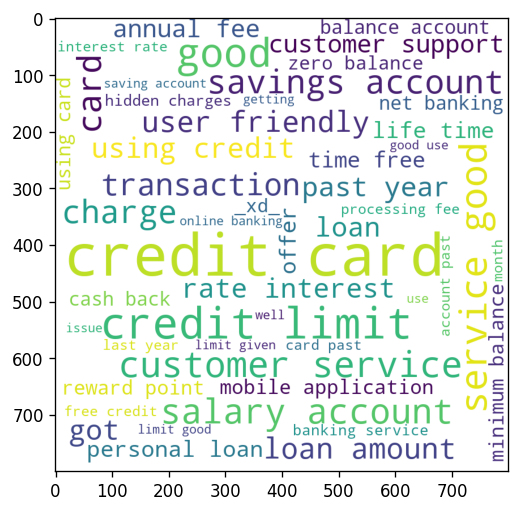

In [197]:
word_cloud(axis_words,"Axis Bank")

WordCloud Union Bank of India


WordCloud for Union Bank of India : 



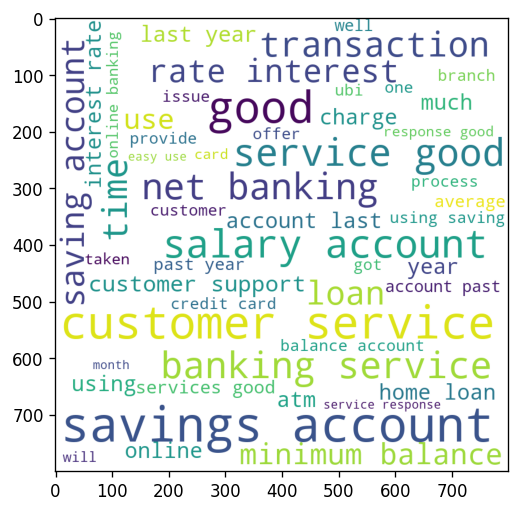

In [198]:
word_cloud(union_words,"Union Bank of India")

WordCloud Capital First Bank


WordCloud for Capital First Bank : 



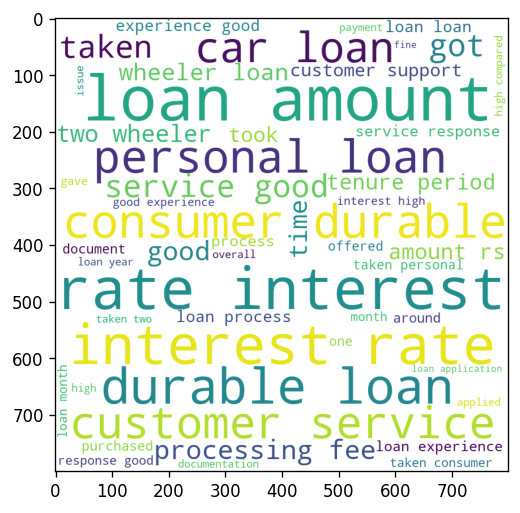

In [199]:
word_cloud(capital_words,"Capital First Bank")

WordCloud CitiBank


WordCloud for CitiBank : 



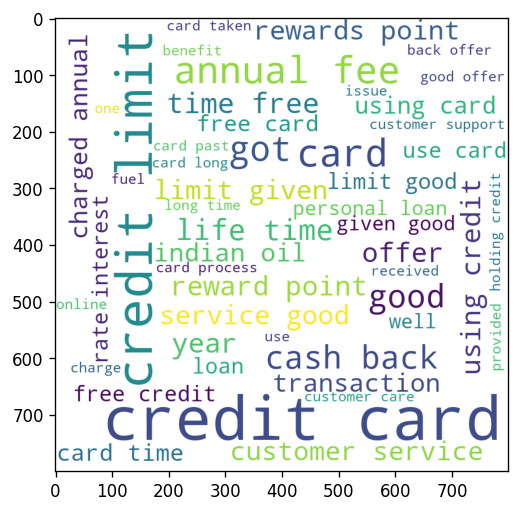

In [200]:
word_cloud(citi_words,"CitiBank")

WordCloud Bank of India


WordCloud for Bank of India : 



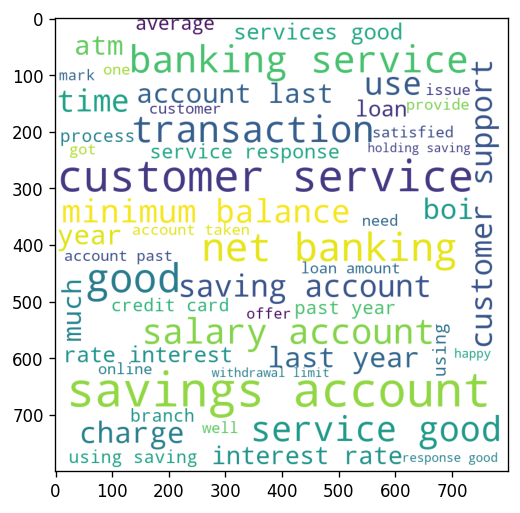

In [201]:
word_cloud(boi_words,"Bank of India")

Attempt was made to make the wordcloud according to the bank logo but it wasnt looking good

In [202]:
'''
from PIL import Image

!wget https://www.pngfind.com/pngs/b/682-6829846_axis-bank-logo-png.png

mask =np.array(Image.open("/content/682-6829846_axis-bank-logo-png.png"))

transformed_mask = np.ndarray((mask.shape[0],mask.shape[1],mask.shape[2]), np.int32)

for i in range(len(mask)):
  for j in range(len(mask[i])):
    for k in range(len(mask[i][j])):
      if mask[i][j][k]==0:
        transformed_mask[i][j][k] = 255
      else:
        transformed_mask[i][j][k] = mask[i][j][k]

wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(axis_words)


# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
'''

'\nfrom PIL import Image\n\n!wget https://www.pngfind.com/pngs/b/682-6829846_axis-bank-logo-png.png\n\nmask =np.array(Image.open("/content/682-6829846_axis-bank-logo-png.png"))\n\ntransformed_mask = np.ndarray((mask.shape[0],mask.shape[1],mask.shape[2]), np.int32)\n\nfor i in range(len(mask)):\n  for j in range(len(mask[i])):\n    for k in range(len(mask[i][j])):\n      if mask[i][j][k]==0:\n        transformed_mask[i][j][k] = 255\n      else:\n        transformed_mask[i][j][k] = mask[i][j][k]\n\nwc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,\n               stopwords=stopwords, contour_width=3, contour_color=\'firebrick\')\n\n# Generate a wordcloud\nwc.generate(axis_words)\n\n\n# show\nplt.figure(figsize=[20,10])\nplt.imshow(wc, interpolation=\'bilinear\')\nplt.axis("off")\nplt.show()\n'

# Text Analysis

Importing Libraries

In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score,make_scorer

User Defined Function that returns kappa score

In [204]:
def kappa_score(y_act,y_pred):
  return cohen_kappa_score(y_act,y_pred)

Kappa = make_scorer(kappa_score)

Attempt was made to use randomized search to optimise the hyperparameters of random forest classifier but only minute improvement was seen so commented

In [205]:
'''
rf_param_grid ={
    'max_depth':[50,75,90],
    'n_estimators': [600,800,1000,1300,1750],
    'bootstrap':[True,False],
    'max_features':['auto','sqrt'],
    'min_samples_leaf': [2, 4, 1],
    'min_samples_split': [12, 15,22],
}

from sklearn.model_selection import RandomizedSearchCV

rf=RandomForestClassifier()
rf_random=RandomizedSearchCV(estimator=rf,param_distributions=rf_param_grid,cv=3,verbose=2,n_jobs=-1,)
rf_random.fit(tfidf_mat,df['Title'])
# best parameter
rf_random.best_params_
'''

"\nrf_param_grid ={\n    'max_depth':[50,75,90],\n    'n_estimators': [600,800,1000,1300,1750],\n    'bootstrap':[True,False],\n    'max_features':['auto','sqrt'],\n    'min_samples_leaf': [2, 4, 1],\n    'min_samples_split': [12, 15,22],\n}\n\nfrom sklearn.model_selection import RandomizedSearchCV\n\nrf=RandomForestClassifier()\nrf_random=RandomizedSearchCV(estimator=rf,param_distributions=rf_param_grid,cv=3,verbose=2,n_jobs=-1,)\nrf_random.fit(tfidf_mat,df['Title'])\n# best parameter\nrf_random.best_params_\n"

User Defined Function that returns Tfidf Matrix and Tfidf Object

In [206]:
def get_tfidf_mat(X,max_features = None):
    
  tfidf = TfidfVectorizer(stop_words=stopwords,
                        ngram_range=(1,2),          #keeping ngram max limit as 2 as it was seen that there are words like user friendly etc. May help in classification
                        max_df=0.7,                 #A word should occur in maximum 70% of the sentence otherwise it wont hhelp in distinction  
                        min_df=10,                  #A word should occur in minimum 10 sentence otherwise it wont hhelp in distinction  
                        token_pattern = "[a-z']{3,}",  #only selecting lowercase alphabet with single quote, word with length below 3 is not selected
                        max_features = max_features)    #max_feature is specified as argument depending on need
  

  tfidf_mat = tfidf.fit_transform(X['corpus'])      #Matrix is formed from column corpus
  return tfidf_mat,tfidf

User Defined Function that return list of words most helpfull in classification

In [207]:
def get_feature_importance(X,name):

  #Using Logistic Regression and Random Forest Classifier
  tfidf_mat,tfidf = get_tfidf_mat(X,500)
  lr = LogisticRegression(max_iter=1000)
  rf = RandomForestClassifier(n_estimators = 500)

  #Cross Validating with kappa score
  #Classifying the title with the help of tfidf matrix
  lr_cv = np.mean(cross_val_score(lr,X=tfidf_mat, y=X['Title'],cv=5,scoring=Kappa))
  rf_cv = np.mean(cross_val_score(rf,X=tfidf_mat, y=X['Title'],cv=5,scoring=Kappa))

  #Printing the Mean CV score for both the models
  print(f'Mean CV score for Logistic Regression of {name}: ',lr_cv)
  print(f'Mean CV score for Random Forest Classifier of {name}: ',rf_cv,'\n\n')

  #Selecting the model with higher mean cv score
  #Appending the important words helpful in classification into a list
  imp_vocab = []
  if rf_cv>lr_cv:
    rf.fit(X=tfidf_mat,y=X['Title'])
    reverse_vocab = {v:k for k,v in tfidf.vocabulary_.items()}
    
    for k in np.argsort(rf.feature_importances_)[::-1]:
      imp_vocab.append(reverse_vocab[k])
  
  else:
    lr.fit(X=tfidf_mat,y=X['Title'])
    reverse_vocab = {v:k for k,v in tfidf.vocabulary_.items()}

    for k in np.argsort(lr.coef_[0])[::-1]:
      imp_vocab.append(reverse_vocab[k])
  
  return imp_vocab

Feature Importance of words to classify the title for the entire dataframe

In [208]:
banks_feature_importance = get_feature_importance(df,'Entire Datframe')

Mean CV score for Logistic Regression of Entire Datframe:  0.9003652231196252
Mean CV score for Random Forest Classifier of Entire Datframe:  0.9010079609386551 




Displaying the most usefull words in classification of title as WordCloud


WordCloud for Bank Important Vocab : 



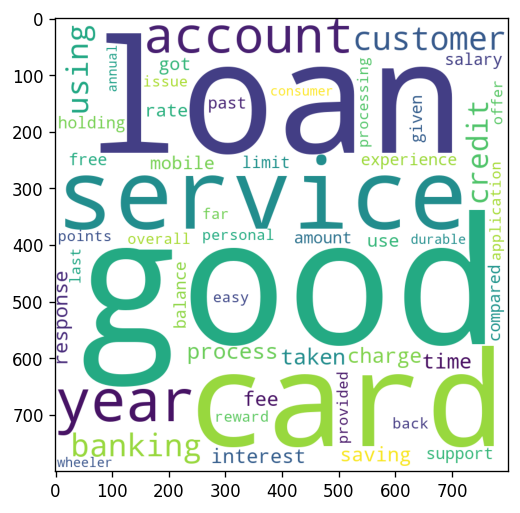

In [209]:
word_cloud(' '.join(banks_feature_importance),'Bank Important Vocab')

Words Like Account, Good, Credit, Service, Loan are most usefull in classifying the title

## Indidual Bank Classification

Creating Individual Dataframe for each Bank

In [210]:
df_axis = df[df['Bank']=='Axis Bank']
df_union = df[df['Bank']=='Union Bank Of India']
df_capital = df[df['Bank']=='Capital First']
df_citi = df[df['Bank']=='Citibank']
df_boi = df[df['Bank']=='Bank Of India']

Feature Importance of words to classify the title for the Individual Bank dataframe

In [211]:
axis_feature_importance = get_feature_importance(df_axis,'Axis Bank Dataframe')
union_feature_importance = get_feature_importance(df_union,'Union Bank Dataframe')
capital_feature_importance = get_feature_importance(df_capital,'Capital First Bank Dataframe')
citi_feature_importance = get_feature_importance(df_citi,'Citi Bank Dataframe')
boi_feature_importance = get_feature_importance(df_boi,'Bank of India Dataframe')

Mean CV score for Logistic Regression of Axis Bank Dataframe:  0.8982383787123552
Mean CV score for Random Forest Classifier of Axis Bank Dataframe:  0.9145255499397562 


Mean CV score for Logistic Regression of Union Bank Dataframe:  0.775250698599799
Mean CV score for Random Forest Classifier of Union Bank Dataframe:  0.8517608545487236 


Mean CV score for Logistic Regression of Capital First Bank Dataframe:  0.8582996756951333
Mean CV score for Random Forest Classifier of Capital First Bank Dataframe:  0.8580331211857672 


Mean CV score for Logistic Regression of Citi Bank Dataframe:  0.8054778381975192
Mean CV score for Random Forest Classifier of Citi Bank Dataframe:  0.8665542623713456 


Mean CV score for Logistic Regression of Bank of India Dataframe:  0.6608265425227777
Mean CV score for Random Forest Classifier of Bank of India Dataframe:  0.7646047524380901 




Word with higher font are most useful in classifying the title


WordCloud for Axis Bank Important Vocab : 



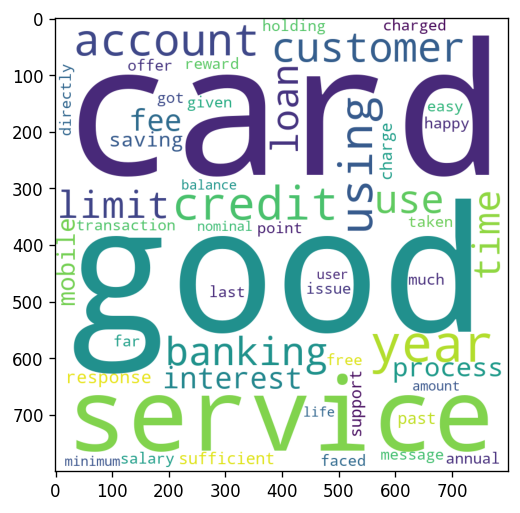

In [212]:
word_cloud(' '.join(axis_feature_importance),'Axis Bank Important Vocab')


WordCloud for Union Bank of India Important Vocab : 



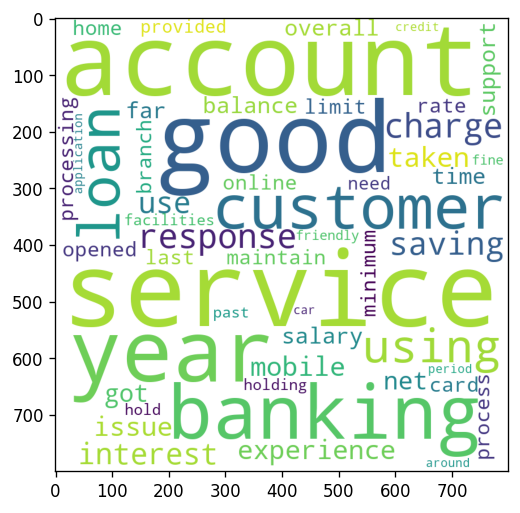

In [213]:
word_cloud(' '.join(union_feature_importance),'Union Bank of India Important Vocab')


WordCloud for Capital First Bank Important Vocab : 



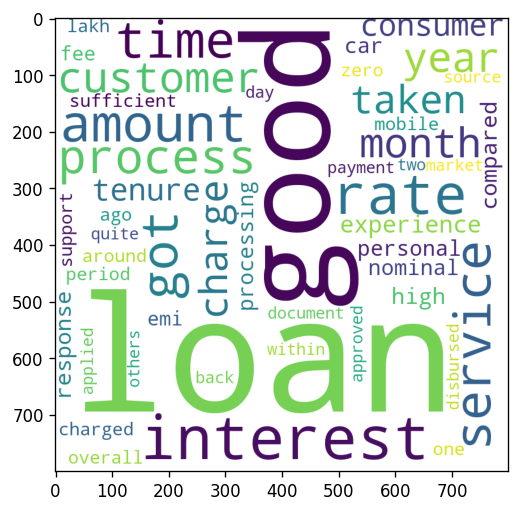

In [214]:
word_cloud(' '.join(capital_feature_importance),'Capital First Bank Important Vocab')


WordCloud for CitiBank Important Vocab : 



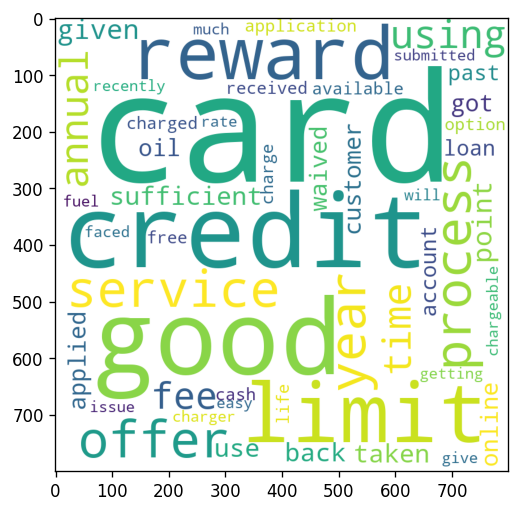

In [215]:
word_cloud(' '.join(citi_feature_importance),'CitiBank Important Vocab')


WordCloud for Bank of India Important Vocab : 



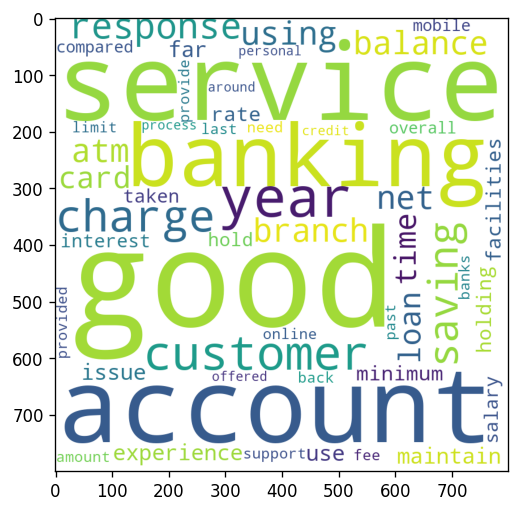

In [216]:
word_cloud(' '.join(boi_feature_importance),'Bank of India Important Vocab')

## LSA

Calling tfidf user defined function to get matrix and object

In [217]:
tfidf_mat,tfidf = get_tfidf_mat(df)

Truncated SVD

In [218]:
#Calculating the rank of the matrix
if tfidf_mat.shape[0]<tfidf_mat.shape[1]:
  k=tfidf_mat.shape[0]-1
else:
  k=tfidf_mat.shape[1]-1

#Calculating the U, S, V matrix 
U, S, V = svds(tfidf_mat,k = k)

In [219]:
S1 = S.copy()
S1.sort()
S2 = S1[::-1]
S3 = S2.cumsum()/S2.sum()

#70% of the total sum of the singular value used to form object
tsvd = TruncatedSVD(n_components=sum(S3<0.7))       

In [220]:
tsvd_mat = tsvd.fit_transform(tfidf_mat)

In [221]:
#tsvd.singular_values_

In [222]:
#tsvd.transform(tfidf_mat) # U matrix of S
#tsvd_word = TruncatedSVD(n_components=628)
#tsvd_word_mat = tsvd_word.fit_transform(tfidf_mat.T)  # V matrix of SVD ==> word vector

Plotting using TSNE

In [223]:
tsne = TSNE(n_components=2, n_iter=1500, n_jobs = -1)   #plotting in 2-d
tsne_mat = tsne.fit_transform(tsvd_mat)

In [224]:
topic_num = preprocessing.LabelEncoder().fit_transform(df.Title)        

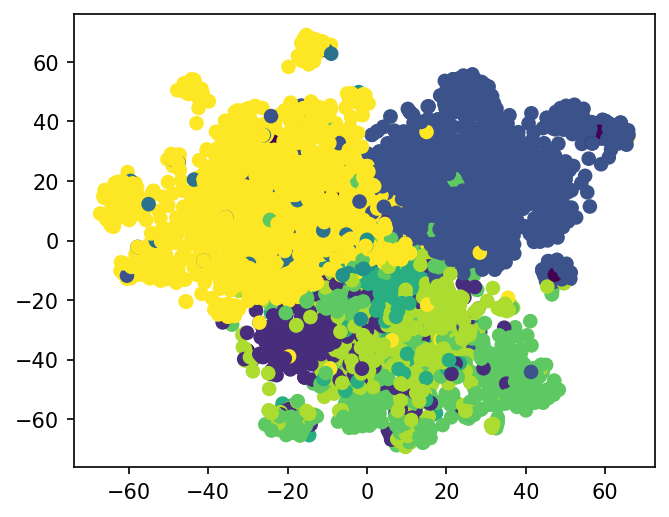

In [225]:
plt.figure(figsize=(5,4),dpi=150)
plt.scatter(tsne_mat[:,0],tsne_mat[:,1],c = topic_num)  # shows document cluster

Clusters can be distinguished as pattern is seen

Testing with a Query

In [226]:
#query = 'I want to buy a home. Can i take a loan for it?'  
#query = 'I took a car loan from the Bank. Customer Support and service was very good'
query = 'I want to open an account for my personal needs. What type of bank account shall I open?'

In [227]:
query = query.lower()
query_doc = tsvd.transform(tfidf.transform([query]))

In [228]:
#Using Pairwise to calculate cosine distance
d = pairwise_distances (X=tsvd_mat, Y=query_doc, metric="cosine")

In [229]:
df['Title'][np.argmin(d.flatten())] 

'Saving Account'

Model is doing great in terms of identifying the Title.<br>Check by changing the query.

## Sentiment

Classifying Rating above or equal 4 as positive and less than 4 as negative

In [230]:
data = df.copy()
data['Sentiment'] = df['Rating'].apply(lambda x: 'Positive' if x>=4 else 'Negative')

#lowring the case of heading
data['Heading'] = data['Heading'].apply(lambda x: x.lower().strip())

Similar as before a user defined function to return tfidf matrix

In [231]:
def get_tfidf_mat_sem(X,max_features = None):
    
  tfidf = TfidfVectorizer(stop_words=stopwords,
                        ngram_range=(1,2),
                        max_df=0.7,
                        min_df=10,
                        token_pattern = "[a-z']{3,}",
                        max_features = max_features)
  
  tfidf_mat = tfidf.fit_transform(X)
  return tfidf_mat,tfidf

Running the same command as before but on Semantics now

In [ ]:
tfidf_mat,tfidf = get_tfidf_mat_sem(data['corpus'])

if tfidf_mat.shape[0]<tfidf_mat.shape[1]:
  k=tfidf_mat.shape[0]-1
else:
  k=tfidf_mat.shape[1]-1

U, S, V = svds(tfidf_mat,k = k)

S1 = S.copy()
S1.sort()
S2 = S1[::-1]
S3 = S2.cumsum()/S2.sum()

tsvd = TruncatedSVD(n_components=sum(S3<0.7))
tsvd_mat = tsvd.fit_transform(tfidf_mat)

tsne = TSNE(n_components=2, n_iter=1500, n_jobs = -1)
tsne_mat = tsne.fit_transform(tsvd_mat)

topic_num = preprocessing.LabelEncoder().fit_transform(data.Semantics)
plt.scatter(tsne_mat[:,0],tsne_mat[:,1],c = topic_num)

No relation seen in the cluster

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr_cv = np.mean(cross_val_score(lr,X=tfidf_mat, y=data['Sentiment'],cv=5,scoring=Kappa))
lr_cv

Very Low CV score

In [ ]:
query = 'The service was bad, customer support was terrible.'
#query = 'Took a loan from the bank. Excellent Service and Customer Support. Transaction very fast'
query = query.lower()
query_doc = tsvd.transform(tfidf.transform([query]))

d = pairwise_distances (X=tsvd_mat, Y=query_doc, metric="cosine")

data['Sentiment'].iloc[np.argmin(d.flatten()),] 

Model failed to identify correct Sentiment.<br>Returns Positive for most queries

Using words from column Heading to classify the Sentiment

In [ ]:
tfidf_mat,tfidf = get_tfidf_mat_sem(data['Heading'])

if tfidf_mat.shape[0]<tfidf_mat.shape[1]:
  k=tfidf_mat.shape[0]-1
else:
  k=tfidf_mat.shape[1]-1

U, S, V = svds(tfidf_mat,k = k)

S1 = S.copy()
S1.sort()
S2 = S1[::-1]
S3 = S2.cumsum()/S2.sum()

tsvd = TruncatedSVD(n_components=sum(S3<0.7))
tsvd_mat = tsvd.fit_transform(tfidf_mat)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr_cv = np.mean(cross_val_score(lr,X=tfidf_mat, y=data['Sentiment'],cv=5,scoring=Kappa))
lr_cv

Much Better CV Score

In [ ]:
query = 'The service was bad, customer support was terrible.'
#query = 'Took a loan from the bank. Excellent Service and Customer Support. Transaction very fast'

query = query.lower()
query_doc = tsvd.transform(tfidf.transform([query]))

d = pairwise_distances (X=tsvd_mat, Y=query_doc, metric="cosine")

data['Sentiment'].iloc[np.argmin(d.flatten()),] 

Heading of the review is actually doing better in terms of predicting the Sentiment

# Reference

Attempt was made to keep the codes as original as possible. Most of codes used are discussed in the class.<br>
Help was taken from stackoverflow on several occassions so not posting all the links